In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

from sklearn.cluster import KMeans
import os

In [3]:
current_dir = os.getcwd()
code_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'codes'))
data_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'data'))

In [31]:
# 读取图像
img = cv2.imread(os.path.join(data_path, 'test_RGB2.png'))
# img = cv2.resize(img, (1548, 1290))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

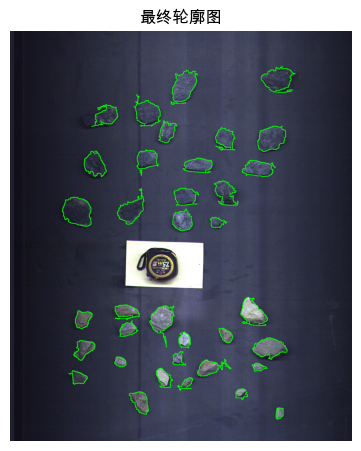

In [32]:
# 转为灰度图

# 高斯模糊（可减少噪点）
# img_gray = cv2.GaussianBlur(img_gray, (1, 1), 0)

gray = img_gray

# CLAHE增强局部对比度
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_enhanced = clahe.apply(gray)

# gray_enhanced = cv2.medianBlur(gray_enhanced, 1)

# Canny边缘检测 50, 300
edges = cv2.Canny(gray_enhanced, threshold1=50, threshold2=258)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# edges_dilated = cv2.dilate(edges, kernel, iterations=1)
# edges_smoothed = cv2.erode(edges_dilated, kernel, iterations=1)

# 替换 dilate + erode 为 closing（先膨胀再腐蚀，封闭小缝隙）
edges_smoothed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)

# 查找所有轮廓
contours, _ = cv2.findContours(edges_smoothed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 设置面积阈值，过滤掉太小的轮廓
min_area = 500  # 可根据图像大小调整
max_area = 20000
filtered_contours = [cnt for cnt in contours if max_area > cv2.contourArea(cnt) > min_area]

# 绘制轮廓
contour_img = img.copy()
cv2.drawContours(contour_img, filtered_contours, -1, (0, 255, 0), 2)

# 显示所有中间步骤
plt.figure(figsize=(18, 6))

# plt.subplot(1, 5, 1)
# plt.title("原图")
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(1, 5, 2)
# plt.title("灰度+CLAHE增强")
# plt.imshow(gray_enhanced, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 3)
# plt.title("Canny边缘+膨胀")
# plt.imshow(edges_dilated, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 4)
# plt.title("Canny边缘+膨胀+腐蚀")
# plt.imshow(edges_smoothed, cmap='gray')
# plt.axis('off')

plt.subplot(1, 5, 5)
plt.title("最终轮廓图")
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


In [299]:
len(contours)

1742

In [227]:
results = []

for i, cnt in enumerate(filtered_contours):
    # 创建与原图同大小的黑色 mask
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    # 在 mask 上绘制当前轮廓，填充区域
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    # 获取该轮廓对应的 RGB 像素（使用 mask 提取）
    masked_pixels = img[mask == 255]  # 这是一个 Nx3 的数组，每行为一个 RGB

    # 计算质心
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    # 保存
    results.append({
        "id": i,
        "centroid": (cx, cy),
        "pixels_rgb": masked_pixels,  # ndarray, shape: (N, 3)
        "mean_rgb": np.mean(masked_pixels, axis=0)  # 平均颜色，可选
    })

# # 可打印查看前几个
# for item in results[:5]:
#     print(f"矿石 {item['id']}:")
#     print(f"  质心: {item['centroid']}")
#     print(f"  像素数量: {item['pixels_rgb'].shape[0]}")
#     print(f"  平均 RGB: {item['mean_rgb']}")
#     print("-" * 30)


### kmeans 分类

In [256]:
# 从结果中提取平均 RGB 向量
rgb_values = np.array([r["mean_hsv"] for r in results])  # shape: (N, 3)

# 设置聚类个数
num_clusters = 2

# 聚类
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto")
labels = kmeans.fit_predict(rgb_values)

# 将聚类结果加入原结果
for i, r in enumerate(results):
    r["cluster"] = int(labels[i])  # 转 int 避免 JSON 问题

# 打印各类别数量
from collections import Counter
print("聚类结果统计：", Counter(labels))

聚类结果统计： Counter({0: 19, 1: 17})


In [257]:
# 复制一份图像
img_with_labels = img.copy()

# 分类颜色标识（可调）
cluster_colors = {
    0: (0, 0, 255),   # 类别 0 用蓝色
    1: (0, 255, 0)    # 类别 1 用绿色
}

for r, cnt in zip(results, filtered_contours):
    cx, cy = r["centroid"]
    cluster_id = r["cluster"]
    color = cluster_colors[cluster_id]

    # 绘制轮廓（不同类别用不同颜色）
    cv2.drawContours(img_with_labels, [cnt], -1, color, 2)

    # 标注类别编号
    label = f"C{cluster_id}"
    cv2.putText(img_with_labels, label, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

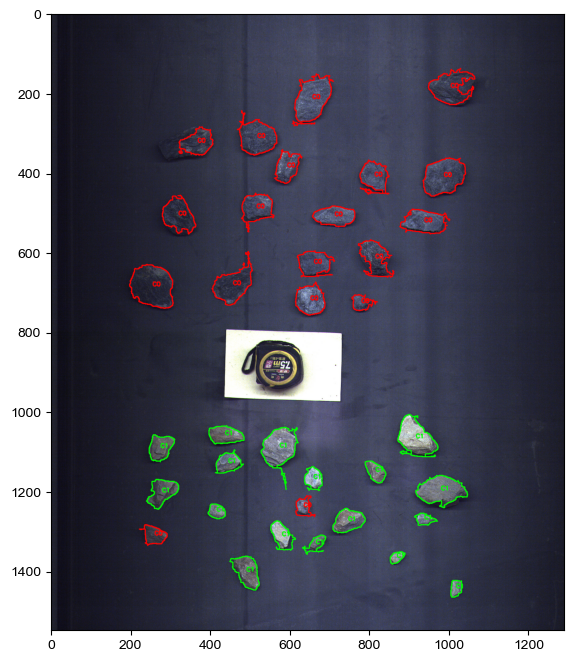

In [258]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))

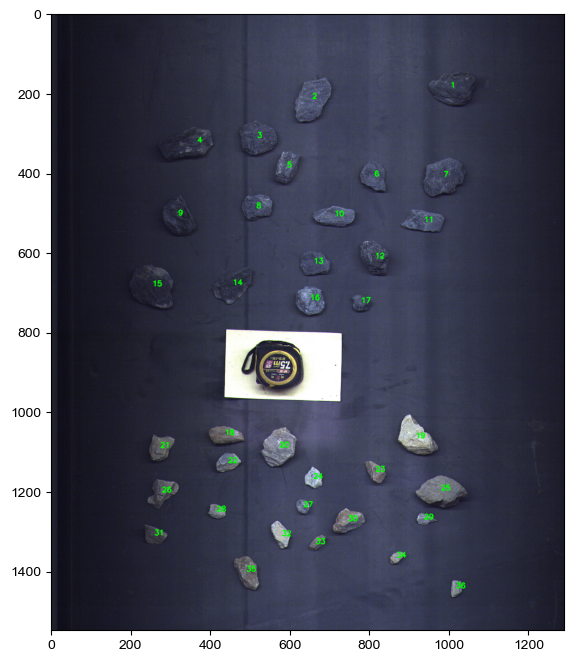

In [259]:
# 按质心的 y 坐标排序（从上往下）
results_sorted = sorted(results, key=lambda r: r["centroid"][1])

img_numbered = img.copy()

for idx, r in enumerate(results_sorted):
    cx, cy = r["centroid"]

    # 用绿色标注编号
    cv2.putText(img_numbered, str(idx + 1), (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_numbered, cv2.COLOR_BGR2RGB))

In [260]:
# 提取所有平均 RGB

def plot_color_dis(color, results):
    rgb_array = np.array([r[color] for r in results])  # shape: (N, 3)
    R, G, B = rgb_array[:, 0], rgb_array[:, 1], rgb_array[:, 2]

    plt.figure(figsize=(12, 4))

    # R
    plt.subplot(1, 3, 1)
    plt.hist(R, bins=30, color='red', alpha=0.7)
    plt.title("Red Channel Histogram")
    plt.xlabel("R value")
    plt.ylabel("Count")

    # G
    plt.subplot(1, 3, 2)
    plt.hist(G, bins=30, color='green', alpha=0.7)
    plt.title("Green Channel Histogram")
    plt.xlabel("G value")

    # B
    plt.subplot(1, 3, 3)
    plt.hist(B, bins=30, color='blue', alpha=0.7)
    plt.title("Blue Channel Histogram")
    plt.xlabel("B value")

    plt.tight_layout()


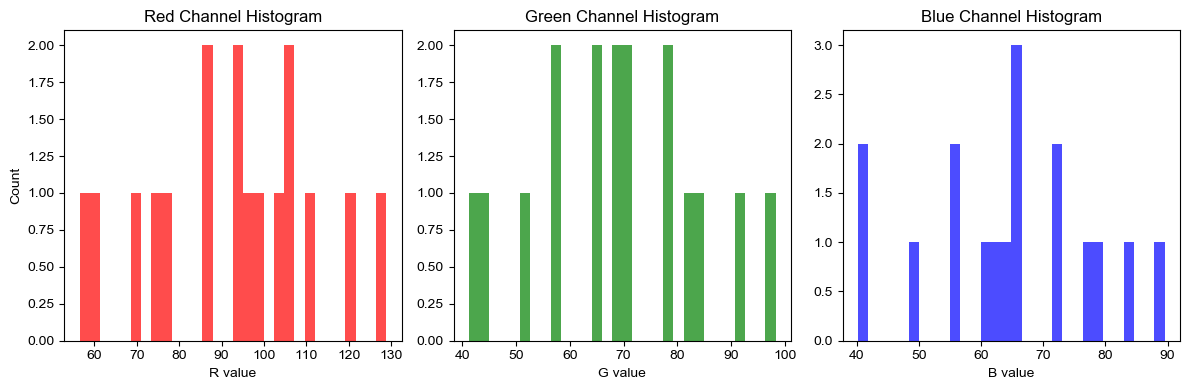

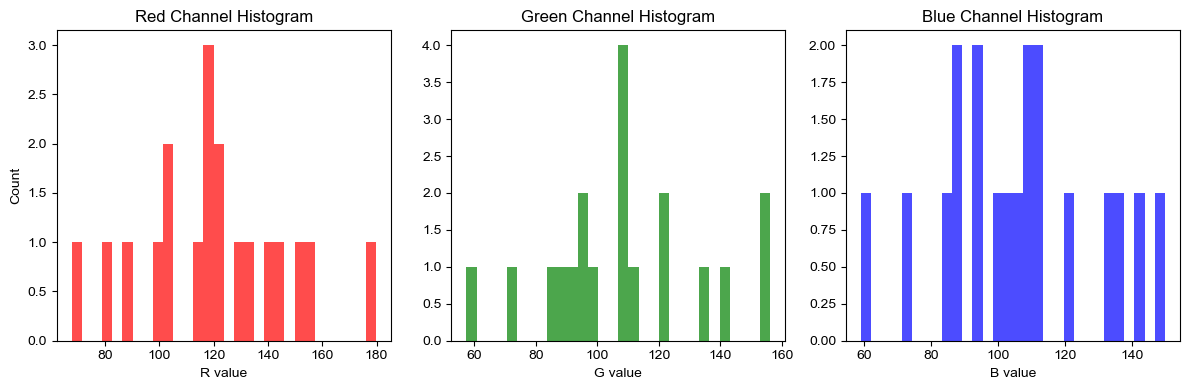

In [263]:
plot_color_dis('mean_rgb', results_sorted[0:17])
plot_color_dis('mean_rgb', results_sorted[17:])

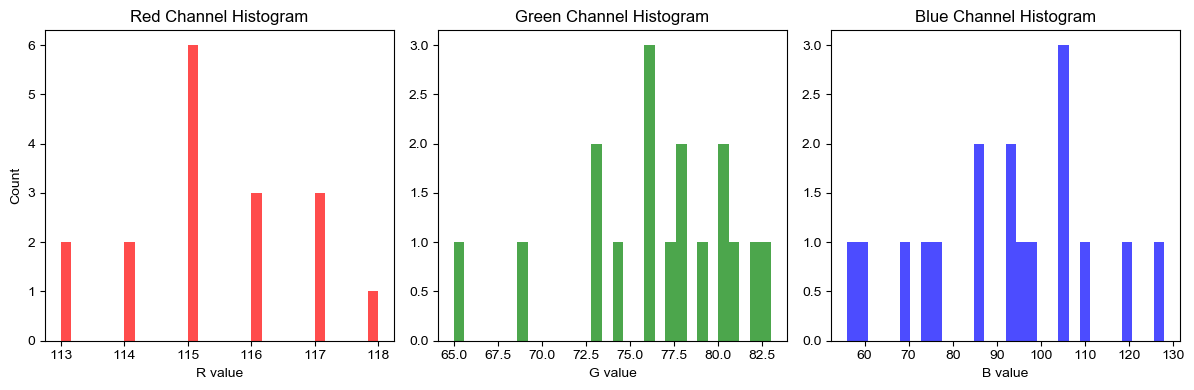

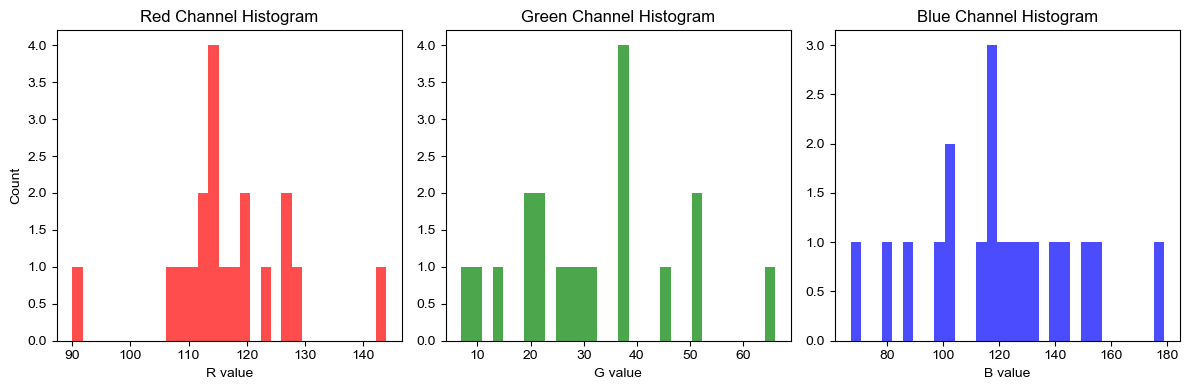

In [264]:
plot_color_dis('mean_hsv', results_sorted[0:17])
plot_color_dis('mean_hsv', results_sorted[17:])

In [281]:
results_sorted[26]['mean_hsv']

array([114,  66, 120], dtype=uint8)

In [285]:
results_sorted[3]['mean_hsv']

array([117,  65,  74], dtype=uint8)

### 颜色阈值分类

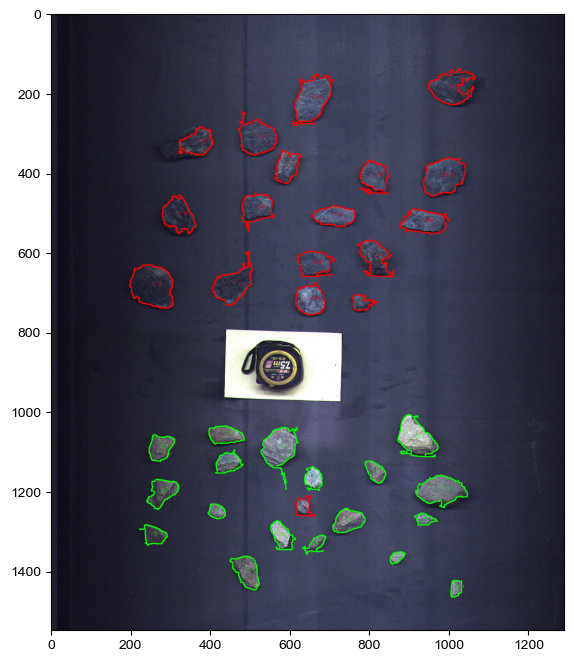

In [286]:
def rgb_to_hsv(rgb):
    color = np.uint8([[rgb]])  # 转换为 OpenCV 的格式
    hsv = cv2.cvtColor(color, cv2.COLOR_RGB2HSV)
    return hsv[0, 0]  # 返回 H, S, V

for r in results:
    mean_rgb = r["mean_rgb"]  # (R, G, B)
    # 注意 OpenCV 默认是 BGR
    mean_bgr = (mean_rgb[2], mean_rgb[1], mean_rgb[0])  # 转换为 BGR
    r["mean_hsv"] = rgb_to_hsv(mean_bgr)  # 例如：[H, S, V]

# 自定义分类规则
for r in results:
    H, S, V = r["mean_hsv"]

    if S < 65:
        r["class_by_color"] = 1
    else:
        r["class_by_color"] = 0
        
img_colorclass = img.copy()

for r, cnt in zip(results, filtered_contours):
    cx, cy = r["centroid"]
    cluster_id = r["class_by_color"]
    color = cluster_colors[cluster_id]

    label = f"C {cluster_id}"
    cv2.drawContours(img_colorclass, [cnt], -1, color, 2)
    cv2.putText(img_colorclass, label, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_colorclass, cv2.COLOR_BGR2RGB))

In [248]:
results[0]['mean_hsv']

array([107,  37, 131], dtype=uint8)

轮廓总数：46
面积范围：4.0 - 50554.0
平均面积：4132.2
中位数面积：3168.0


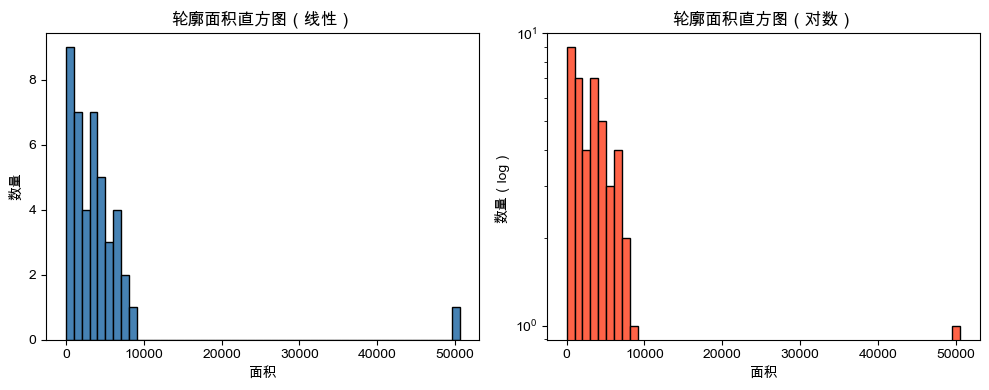

In [224]:
# 计算每个轮廓的面积
areas = [cv2.contourArea(cnt) for cnt in contours]

# 可选：过滤掉太小的值防止干扰直方图可视化
areas_filtered = [a for a in areas if a > 10]

# 统计信息
print(f"轮廓总数：{len(areas)}")
print(f"面积范围：{min(areas):.1f} - {max(areas):.1f}")
print(f"平均面积：{np.mean(areas):.1f}")
print(f"中位数面积：{np.median(areas):.1f}")

# 绘制面积直方图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(areas_filtered, bins=50, color='steelblue', edgecolor='black')
plt.title("轮廓面积直方图（线性）")
plt.xlabel("面积")
plt.ylabel("数量")

plt.subplot(1, 2, 2)
plt.hist(areas_filtered, bins=50, log=True, color='tomato', edgecolor='black')
plt.title("轮廓面积直方图（对数）")
plt.xlabel("面积")
plt.ylabel("数量（log）")

plt.tight_layout()
plt.show()